In [1]:
import h5py
import scipy
import numpy as np
import os
import zlib
import msgpack
from sklearn.utils import sparsefuncs
import pickle
import json
import pandas as pd
import random 

def read_compressed_json(json_path):
	if not os.path.isfile(json_path):
		return {}
	with open(json_path, 'rb') as f:
		o = f.read()
		o = zlib.decompress(o)
		o = msgpack.unpackb(o, strict_map_key=False)
		return o

In [2]:
GENES_ANNOTATION = read_compressed_json('/home/ub-sonvo-25d094476064960/genes_annotation.json.gz')
N_GENES = GENES_ANNOTATION['n_genes']
DEFAULT_SIZE_FACTOR = 10000
ROOT_DIR = '/home/ub-sonvo-25d094476064960/celltype_prediction'
# TRAINED_STUDIES = open(ROOT_DIR + '/studies_idx_HVG.txt').read().splitlines()
TRAINED_STUDIES = sorted(os.listdir('/home/ub-sonvo-25d094476064960/celltype_prediction/camel_2'))
TERM_MAPPING = read_compressed_json('/home/ub-sonvo-25d094476064960/term_mapping.json.gz')

In [3]:
GENES_ANNOTATION.keys()

dict_keys(['n_genes', 'idx2name', 'name2idx', 'idx_blacklist', 'genes_alias'])

In [4]:
def _normalize_total(csr_matrix, counts):
	csr_matrix = csr_matrix.astype(np.float32)
	counts += counts == 0
	counts = counts / 10000
	sparsefuncs.inplace_row_scale(csr_matrix, 1 / counts)
	return csr_matrix


def normalize_total(csr_cxg, n_genes=N_GENES):
    csr_cxg = csr_cxg[:, :n_genes]
    counts_per_cell = csr_cxg.sum(1)
    counts_per_cell = np.ravel(counts_per_cell)

    csr_cxg = _normalize_total(csr_cxg, counts_per_cell)
    csr_cxg.data = np.log1p(csr_cxg.data)

    return csr_cxg


def convert_library_size(csr_cxg, n_genes=N_GENES, size_factor=DEFAULT_SIZE_FACTOR):
    res = []
    for i in range(50):
        res.append(
            np.sum(
                np.expm1(
                    csr_cxg.data[csr_cxg.indptr[i] : csr_cxg.indptr[i+1]]
                )
            )
        )
    res = [np.round(i) for i in res]
    ori_size_factor = np.unique(res)
    upper_bound = ori_size_factor[0] + ori_size_factor[0] * 0.1
    lower_bount = ori_size_factor[0] - ori_size_factor[0] * 0.1

    if np.all(ori_size_factor > lower_bount) and np.all(ori_size_factor < upper_bound):
        csr_cxg = csr_cxg[:, :n_genes]
        if DEFAULT_SIZE_FACTOR < upper_bound and DEFAULT_SIZE_FACTOR > lower_bount:
            return csr_cxg
            
        csr_cxg.data = np.expm1(csr_cxg.data)
        csr_cxg.data = csr_cxg.data * (DEFAULT_SIZE_FACTOR / ori_size_factor[0])
        csr_cxg.data = np.log1p(csr_cxg.data)
        return csr_cxg
        
    print('cannot find the library size:', ori_size_factor)
    return None

In [5]:
genes_bool = np.load('trained_data_2/genes_bool.npy')
original_meta_arr = np.load('trained_data_2/trained_meta_celltypes_HVG.npy')
studies_idx_arr = np.load('trained_data_2/studies_idx_arr.npy')

In [5]:
new_tree_genes_bool = np.load('trained_data_2/new_tree_genes_bool_2.npy')
new_tree_studies_idx_arr = np.load('trained_data_2/new_tree_studies_idx_arr.npy')
new_tree_major = np.load('trained_data_2/new_tree_major_HVG.npy')
# new_tree_sub = np.load('trained_data_2/new_tree_sub.npy')

In [6]:
np.sum(np.array(GENES_ANNOTATION['idx2name'])[new_tree_genes_bool] == 'CLDN18')

1

In [7]:
x, y = np.unique(new_tree_major, return_counts=True)
x = x[np.argsort(y)[::-1]]
x = [TERM_MAPPING['idx2name'][i] for i in x]
y = y[np.argsort(y)[::-1]]
df = pd.DataFrame({'ct': x, 'count': y})
df

,ct,count
0,Unassigned,3835019
1,"CD4-positive, alpha-beta T cell",925885
2,glial cell,803907
3,neural cell,496902
4,"CD8-positive, alpha-beta T cell",395955
5,B cell,319572
6,macrophage,316278
7,plasma cell,275394
8,epithelial cell,223920
9,innate lymphoid cell,216951


In [ ]:
filtered_indptr = np.load('trained_data_2/filtered_indptr.npy')
filtered_indices = np.load('trained_data_2/filtered_indices.npy')
filtered_data = np.load('trained_data_2/filtered_data.npy')

In [ ]:
for i in range(len(filtered_indptr) - 1):
    start = filtered_indptr[i]
    end = filtered_indptr[i + 1]
    tmp_data = filtered_data[start : end].copy()
    tmp_n_genes = len(tmp_data)
    tmp_sort = np.argsort(tmp_n_genes)
    replaced_data = np.zeros(shape=tmp_n_genes)
    replaced_data[- np.minimum(tmp_n_genes, 5000):] = np.arange(1, 5001)[- np.minimum(tmp_n_genes, 5000):]
    filtered_data[start : end] = replaced_data

In [ ]:
final_matrix = scipy.sparse.csr_matrix((filtered_data, filtered_indices, filtered_indptr), shape=(5033871, 12491))
final_matrix = final_matrix[np.nonzero(meta != 0)[0], :]

In [8]:
meta = new_tree_major[new_tree_major != 0]

In [9]:
meta.shape

(5330086,)

In [10]:
study_n_classes = []
for i in np.unique(new_tree_studies_idx_arr):
    study_n_classes.append(
        len(
            np.unique(
                meta[new_tree_studies_idx_arr[new_tree_major != 0] == i]
            )
        )
    )

In [11]:
n_epochs = 1
class_idx, class_count = np.unique(meta, return_counts=True)
class_count *= n_epochs
original_weights = np.array([len(meta) / (len(class_idx) * class_count[i]) for i in range(len(class_idx))])
all_weights = original_weights + (2 - np.min(original_weights))
all_weights = np.log2(all_weights)
class_weight_dct = {
    class_idx[i]: all_weights[i]
    for i in range(len(class_idx))
}

In [12]:
class_weight_dct

{6: 1.2037593873388353,
 12: 1.0,
 14: 1.1466660010429535,
 193: 5.584314161187388,
 253: 1.9603238119773174,
 299: 2.8270365075565893,
 336: 2.6840614275435444,
 342: 1.6023445218675045,
 359: 1.3226777923870277,
 383: 2.9456518610448006,
 387: 1.3848668765313414,
 403: 2.987366895480978,
 412: 4.332581369236658,
 413: 1.017396976281918,
 418: 1.4232002243674442,
 425: 1.481235107485198,
 441: 2.281308874482418,
 490: 1.3348766477684464,
 494: 2.321774767012262,
 559: 1.2067784350091506,
 566: 2.994550547423897,
 578: 4.381884492064317,
 600: 2.3100121291220774,
 611: 6.324382205207275,
 613: 2.89252842013755,
 642: 1.0962972207982156,
 731: 1.2495743502848426,
 739: 3.6145192428351565,
 740: 2.582735037324161,
 799: 2.4530523167391634,
 826: 2.972407359694513,
 859: 2.105206224208426,
 871: 1.7307223498214903,
 909: 7.42808770384699,
 977: 4.701369578700827,
 993: 2.814646914614567}

Text(0.5, 1.0, 'log2')

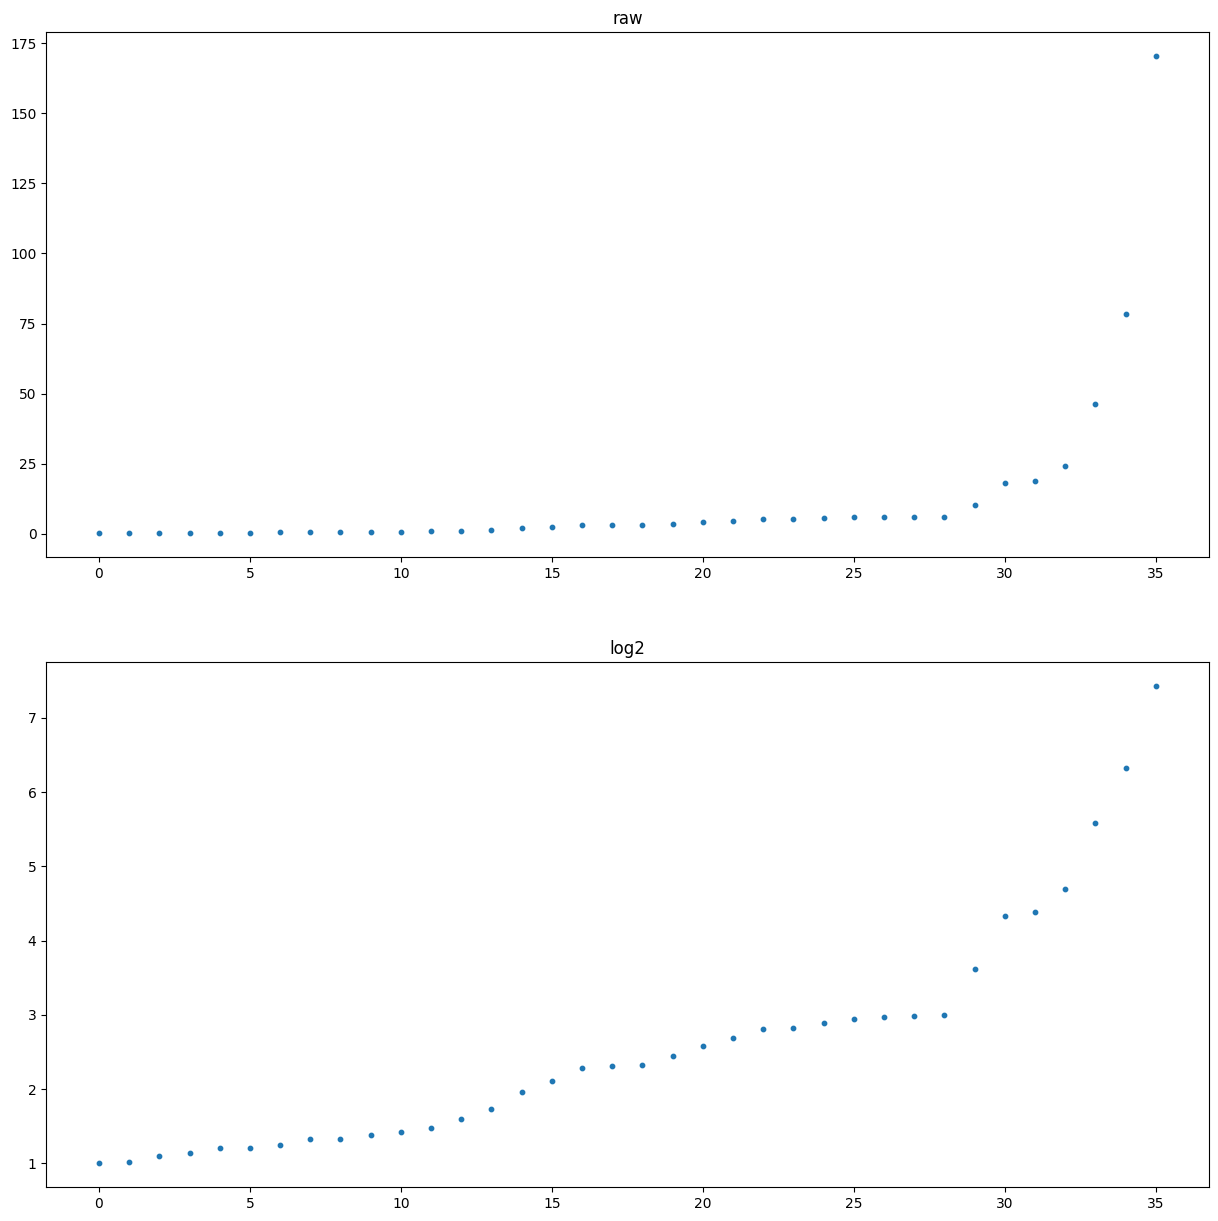

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(15, 15))
tmp_data = original_weights
tmp_idx = np.argsort(tmp_data)
axs[0].scatter(np.arange(len(tmp_idx)), tmp_data[tmp_idx], s=10)
axs[0].set_title('raw')

axs[1].scatter(np.arange(len(tmp_idx)), all_weights[tmp_idx], s=10)
axs[1].set_title('log2')

In [16]:
import numpy as np
from sklearn import linear_model

clf = linear_model.SGDClassifier(
    loss='modified_huber',
    random_state=100,
    class_weight=class_weight_dct,
    max_iter=5000, 
    tol=1e-5,
    verbose=1,
)

In [17]:
for i in np.argsort(study_n_classes):
    study_idx = TRAINED_STUDIES[i]
    print(study_idx, '- start')
    tmp_meta_arr = new_tree_major[new_tree_studies_idx_arr == i]
    tmp_cell_bool = tmp_meta_arr > 0
    if np.sum(tmp_cell_bool) == 0:
        print ('!!!!!WARNING: No metadata, skip study:', study_idx)
        continue
    
    hdf5_path = os.path.join(ROOT_DIR, 'camel_2', str(study_idx), 'raw.hdf5')
    with h5py.File(hdf5_path) as f:
        bc = f['barcodes'][()]
        fe = f['features'][()]
        indptr = f['expression']['indptr'][()].astype(np.int32)
        indices = f['expression']['indices'][()].astype(np.int32)
        try:
            raw = f['expression']['raw'][()].astype(np.float32)
        except:
            raw = f['expression']['lognorm'][()].astype(np.float32)

    # print(study_idx, '- create_matrix')
    tmp_mtx = scipy.sparse.csr_matrix((raw, indices, indptr), shape=(len(fe), len(bc)))
    tmp_mtx = tmp_mtx.T.tocsr()

    # print(study_idx, '- lognormalize matrix')
    is_raw_matrix = False
    if (not np.all(raw.astype('int') == raw) and np.sum(raw > 30) > 0) or np.all(raw.astype('int') == raw):
        is_raw_matrix = True

    if is_raw_matrix:
        tmp_mtx = normalize_total(tmp_mtx)
    else:
        tmp_mtx = convert_library_size(tmp_mtx)

    if tmp_mtx is None:
        print ('!!!!!WARNING: Cannot lognormalize, Skip study:', study_idx)
        continue
    # print (tmp_mtx.shape)
    # print (np.nonzero(tmp_cell_bool)[0])
    # print (np.nonzero(genes_bool)[0])
    tmp_mtx = tmp_mtx[
        np.nonzero(tmp_cell_bool)[0],
        :
    ]
    tmp_mtx = tmp_mtx[
        :,
        np.nonzero(new_tree_genes_bool)[0]
    ]
    # print (np.unique(tmp_meta_arr[tmp_cell_bool]))
    print(study_idx, '- partial_fit')
    clf.partial_fit(
        tmp_mtx, 
        tmp_meta_arr[tmp_cell_bool], 
        classes=class_idx
    )
filename = 'trained_data_2/new_tree_rerun_meta_louvain3_F1_06_SGD_partial_fit_study_batch_HVG_log2_meta_weight_modified_huber_5000iter_tol_1e-5_sorted_n_classes_ASC_2.sav'
pickle.dump(clf, open(filename, 'wb'))

2819 - start
!!!!!WARNING: No metadata, skip study: 2819
2058 - start
!!!!!WARNING: No metadata, skip study: 2058
2085 - start
!!!!!WARNING: No metadata, skip study: 2085
2775 - start
!!!!!WARNING: No metadata, skip study: 2775
2827 - start
!!!!!WARNING: No metadata, skip study: 2827
2846 - start
!!!!!WARNING: No metadata, skip study: 2846
2545 - start
!!!!!WARNING: No metadata, skip study: 2545
2155 - start
!!!!!WARNING: No metadata, skip study: 2155
2892 - start
!!!!!WARNING: No metadata, skip study: 2892
2912 - start
!!!!!WARNING: No metadata, skip study: 2912
2010 - start
!!!!!WARNING: No metadata, skip study: 2010
3044 - start
!!!!!WARNING: No metadata, skip study: 3044
2453 - start
!!!!!WARNING: No metadata, skip study: 2453
2025 - start
!!!!!WARNING: No metadata, skip study: 2025
1736 - start
!!!!!WARNING: No metadata, skip study: 1736
2344 - start
!!!!!WARNING: No metadata, skip study: 2344
3277 - start
!!!!!WARNING: No metadata, skip study: 3277
2360 - start
!!!!!WARNING: No m

In [18]:
clf

SGDClassifier(class_weight={6: 1.2037593873388353, 12: 1.0,
                            14: 1.1466660010429535, 193: 5.584314161187388,
                            253: 1.9603238119773174, 299: 2.8270365075565893,
                            336: 2.6840614275435444, 342: 1.6023445218675045,
                            359: 1.3226777923870277, 383: 2.9456518610448006,
                            387: 1.3848668765313414, 403: 2.987366895480978,
                            412: 4.332581369236658, 413: 1.017396976281918,
                            418: 1.4232002243674442,...
                            441: 2.281308874482418, 490: 1.3348766477684464,
                            494: 2.321774767012262, 559: 1.2067784350091506,
                            566: 2.994550547423897, 578: 4.381884492064317,
                            600: 2.3100121291220774, 611: 6.324382205207275,
                            613: 2.89252842013755, 642: 1.0962972207982156,
                            731: 1.2495743502848426, 739: 3.6145192428351565,
                            740: 2.582735037324161, 799: 2.4530523167391634, ...},
              loss='modified_huber', max_iter=5000, random_state=100, tol=1e-05,
              verbose=1)

In [ ]:
studies_idx_arr = []
for i in range(len(TRAINED_STUDIES)):
    study_idx = TRAINED_STUDIES[i]
    hdf5_path = os.path.join(ROOT_DIR, 'camel', str(study_idx), 'raw.hdf5')
    with h5py.File(hdf5_path) as f:
        bc = f['barcodes'][()]
    tmp = np.zeros(shape=len(bc))
    tmp[:] = i
    studies_idx_arr.append(tmp)

In [ ]:
studies_idx_arr = np.concatenate(studies_idx_arr)
studies_idx_arr = studies_idx_arr.astype('int')
studies_idx_arr = studies_idx_arr[np.nonzero(meta != 0)[0]]

In [ ]:
# studies_idx_arr = np.concatenate(studies_idx_arr)
# studies_idx_arr = studies_idx_arr.astype('int')
# np.save('trained_data_2/studies_idx_arr.npy', studies_idx_arr)

In [ ]:
studies_idx_arr

In [ ]:
np.array(TRAINED_STUDIES)

In [ ]:
for i in np.unique(studies_idx_arr):
    print (i)
    tmp_bool = np.nonzero(studies_idx_arr == i)[0]
    tmp_matrix = final_matrix[tmp_bool, :] 
    tmp_matrix.indptr = tmp_matrix.indptr.astype(np.int32)
    tmp_matrix.indices = tmp_matrix.indices.astype(np.int32)
    tmp_meta = meta[tmp_bool]
    clf.partial_fit(tmp_matrix, tmp_meta, classes=np.unique(meta))

In [ ]:
import pickle

filename = 'trained_data_2/new_tree_rerun_meta_louvain3_F1_06_SGD_partial_fit_study_batch_HVG_log2_meta_weight_modified_huber_5000iter_tol_1e-5_epochs_10.sav'
pickle.dump(clf, open(filename, 'wb'))

In [17]:
clf = pickle.load(open('trained_data_2/new_tree_rerun_meta_louvain3_F1_06_SGD_partial_fit_study_batch_HVG_log2_meta_weight_modified_huber_5000iter_tol_1e-5.sav', 'rb'))

In [18]:
clf

SGDClassifier(class_weight={6: 1.2037593873388353, 12: 1.0,
                            14: 1.1466660010429535, 193: 5.584314161187388,
                            253: 1.9603238119773174, 299: 2.8270365075565893,
                            336: 2.6840614275435444, 342: 1.6023445218675045,
                            359: 1.3226777923870277, 383: 2.9456518610448006,
                            387: 1.3848668765313414, 403: 2.987366895480978,
                            412: 4.332581369236658, 413: 1.017396976281918,
                            418: 1.4232002243674442,...
                            441: 2.281308874482418, 490: 1.3348766477684464,
                            494: 2.321774767012262, 559: 1.2067784350091506,
                            566: 2.994550547423897, 578: 4.381884492064317,
                            600: 2.3100121291220774, 611: 6.324382205207275,
                            613: 2.89252842013755, 642: 1.0962972207982156,
                            731: 1.2495743502848426, 739: 3.6145192428351565,
                            740: 2.582735037324161, 799: 2.4530523167391634, ...},
              loss='modified_huber', max_iter=5000, random_state=100,
              tol=1e-05)

In [48]:
with h5py.File('../camel/1891/raw.hdf5') as f:
    indptr = f['expression']['indptr'][()].astype(np.int32)
    indices = f['expression']['indices'][()].astype(np.int32)
    data = f['expression']['raw'][()]
    bc = f['barcodes'][()]
    fe = f['features'][()]

In [49]:
mtx = scipy.sparse.csr_matrix((data, indices, indptr), shape=(len(fe), len(bc))).T.tocsr()

In [50]:
mtx.data

array([2., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [339]:
# mtx = convert_library_size(mtx)

In [51]:
mtx = normalize_total(mtx)

In [52]:
mtx = mtx[:, :N_GENES][:, np.nonzero(new_tree_genes_bool)[0]]

In [53]:
mtx.shape

(146442, 28725)

In [54]:
res = clf.predict(mtx)
proba_res = clf.predict_proba(mtx)

for i in range(len(res)):
    ct_idx = res[i]
    arr_idx = np.nonzero(clf.classes_ == ct_idx)[0]
    if proba_res[i, arr_idx] < 0.99:
        res[i] = 0

In [55]:
res = [TERM_MAPPING['idx2name'][i] for i in res]
res

['Unassigned',
 'epithelial cell',
 'Unassigned',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'Unassigned',
 'muscle cell',
 'Unassigned',
 'macrophage',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'Unassigned',
 'muscle cell',
 'muscle cell',
 'Unassigned',
 'muscle cell',
 'epithelial cell',
 'muscle cell',
 'Unassigned',
 'muscle cell',
 'muscle cell',
 'endothelial cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'Unassigned',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'epithelial cell',
 'Unassigned',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'Unassigned',
 'endothelial cell',
 'melanocyte',
 'muscle cell',
 'muscle cell',
 'glial cell',
 'muscle cell',
 'Unassigned',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 'Unassigned',
 'muscle cell',
 'muscle cell',
 'muscle cell',
 

In [56]:
x, y = np.unique(res, return_counts=True)

In [57]:
x

array(['B cell', 'CD4-positive, alpha-beta T cell',
       'CD8-positive, alpha-beta T cell', 'Unassigned', 'blood cell',
       'dendritic cell', 'endocrine cell', 'endothelial cell',
       'epithelial cell', 'fibroblast', 'gamma-delta T cell',
       'glial cell', 'granulocyte', 'innate lymphoid cell', 'macrophage',
       'mast cell', 'melanocyte', 'monocyte', 'muscle cell',
       'plasma cell', 'squamous epithelial cell', 'stromal cell'],
      dtype='<U31')

In [58]:
y

array([  221,   172,    85, 38087,    39,   288,   677,  3027,  4807,
         633,     2,  1777,     7,    21,  2039,   167,   579,     2,
       93297,     4,     1,   510])

In [59]:
df = pd.DataFrame({'test': res}, index=bc.astype('str'))

In [60]:
df.index.name = 'Barcodes'
df.to_csv('test_meta.tsv', sep='\t')

In [67]:
ground_truth_meta = np.load('../inference_dir/2154/tmp_major_new_tree.npy')
with h5py.File('../inference_dir/2154/raw.hdf5') as f:
    tmp_bc = f['barcodes'][()].astype('str')
ground_truth_meta = [TERM_MAPPING['idx2name'][i] for i in ground_truth_meta]
df = pd.DataFrame(
    {'ground_truth': ground_truth_meta},
    index=tmp_bc
)
df

,ground_truth
AAACGAATCTCTAGGA-1_1,pneumocyte
AAAGTGACACACACTA-1_1,Unassigned
AACAAAGAGAACCCGA-1_1,pneumocyte
AACCAACGTCGTTTCC-1_1,monocyte
AACCACAAGCACCAGA-1_1,granulocyte
...,...
TTTGTTGAGGTACTGG-1_12,Unassigned
TTTGTTGCAAATACGA-1_12,monocyte
TTTGTTGCATCATTTC-1_12,innate lymphoid cell
TTTGTTGTCAGGACGA-1_12,ciliated cell


In [68]:
df.to_csv('ground_truth.tsv', sep='\t')